In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import os
import gc
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
import random
import tensorflow as tf
print('TensorFlow version: %s' % tf.__version__)

TensorFlow version: 2.3.0


In [10]:
BASE = '../input/bee-vs-wasp/kaggle_bee_vs_wasp/'
img_size=224
batch=32
epochs=50
seed=10

df=pd.read_csv(BASE+'labels.csv')
df.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [11]:
for idx in tqdm(df.index):    
    df.loc[idx,'path']=df.loc[idx,'path'].replace('\\', '/') 
    
df.head()

100%|██████████| 11421/11421 [00:08<00:00, 1310.69it/s]


,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


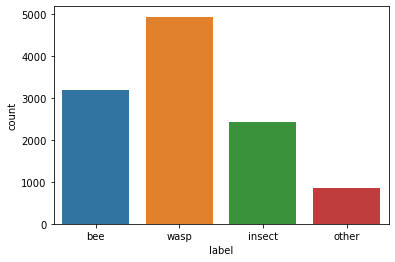

In [12]:
sns.countplot(df['label'])

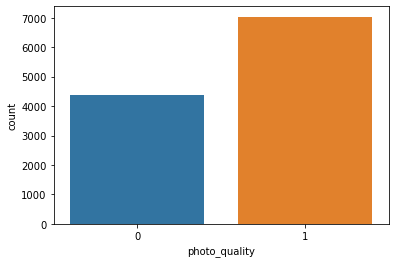

In [13]:
sns.countplot(df['photo_quality'])

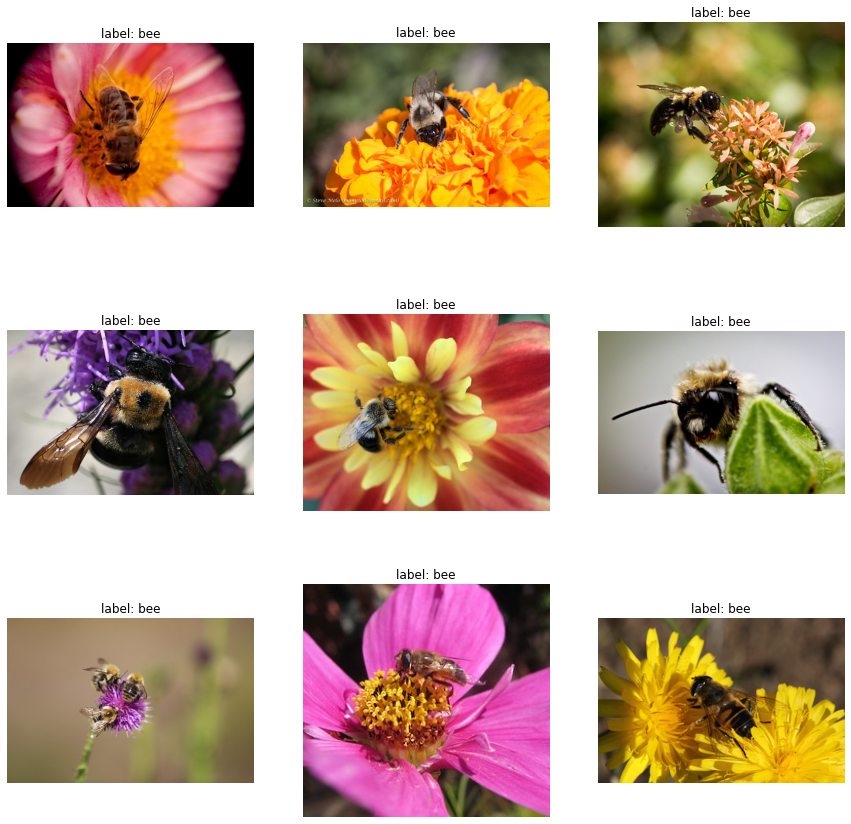

In [14]:
def img_plot(df, label):
    df = df.query('label == @label')
    imgs = []
    for path in df['path'][:9]:
        img = cv2.imread(BASE+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    f, ax = plt.subplots(3, 3, figsize=(15,15))
    for i, img in enumerate(imgs):
        ax[i//3, i%3].imshow(img)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('label: %s' % label)
    plt.show()
    
    
img_plot(df, label='bee')

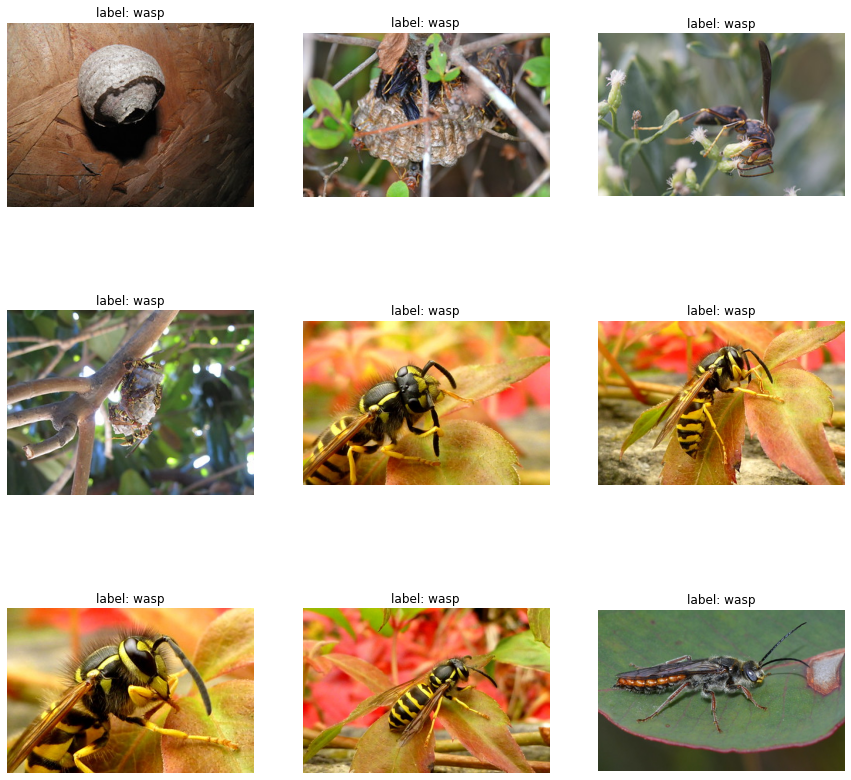

In [15]:
img_plot(df, label='wasp')

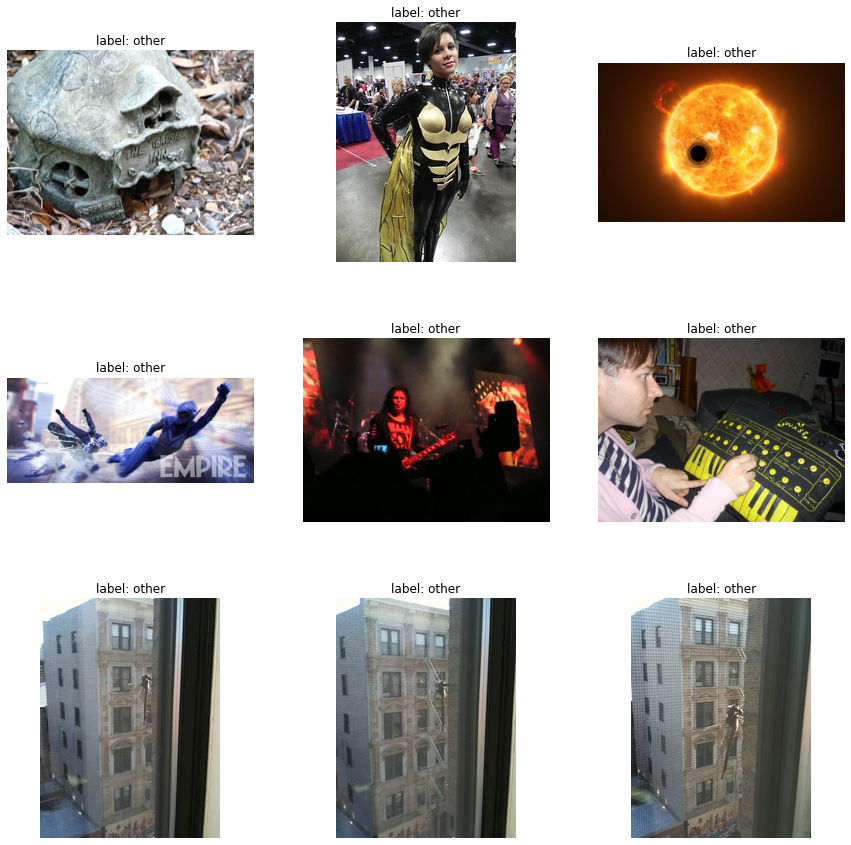

In [16]:
img_plot(df, label='other')

In [17]:
# select only high quality photos
df = df.query('photo_quality == 1')
df['label'].value_counts()

bee       2469
insect    2439
wasp      2127
Name: label, dtype: int64

In [18]:
df.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [19]:
train = df.query('is_validation==0 & is_final_validation==0').reset_index(drop=True)
valid = df.query('is_validation==1').reset_index(drop=True)
test = df.query('is_final_validation==1').reset_index(drop=True)

In [20]:
#Creating Dataset

def create_datasets(df, img_size):
    imgs = []
    for path in tqdm(df['path']):
        img = cv2.imread(BASE+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size,img_size))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    imgs = imgs / 255.0
    df = pd.get_dummies(df['label'])
    return imgs, df


train_imgs, train_df = create_datasets(train, img_size)
val_imgs, val_df = create_datasets(valid, img_size)
test_imgs, test_df = create_datasets(test, img_size)

100%|██████████| 1084/1084 [00:06<00:00, 167.72it/s]


## Model Building

## 1. ResNet 50 pretrained

In [21]:
def build_model(img_size, n):
    inp = Input(shape=(img_size,img_size,n))
    resnet = tf.keras.applications.ResNet50(input_shape=(img_size,img_size,n), 
                                            weights='imagenet', 
                                            include_top=False)
    x = resnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x) 
    opt = tf.keras.optimizers.SGD(momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(224, 3)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


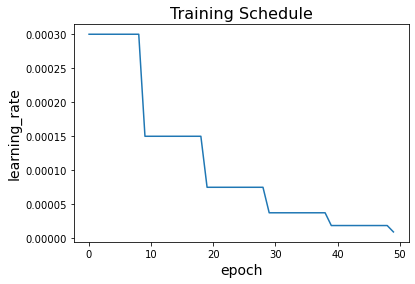

In [22]:
def get_lr_callback(batch_size=32, plot=False):
    start_lr = 3e-4
    def step_decay(epoch):
        drop = 0.5
        epochs_drop = 10.0
        lr = start_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)
    if plot == True:
        rng = [i for i in range(epochs)]
        y = [step_decay(x) for x in rng]
        plt.plot(rng, y)
        plt.xlabel('epoch', size=14)
        plt.ylabel('learning_rate', size=14)
        plt.title('Training Schedule', size=16)
        plt.show()
        
    return lr_callback


get_lr_callback(plot=True)

Epoch 1/20
154/154 [==============================] - 31s 202ms/step - loss: 0.6370 - accuracy: 0.7410 - val_loss: 1.3214 - val_accuracy: 0.2886
Epoch 2/20
154/154 [==============================] - 28s 185ms/step - loss: 0.2974 - accuracy: 0.8902 - val_loss: 1.9554 - val_accuracy: 0.3001
Epoch 3/20
154/154 [==============================] - 29s 186ms/step - loss: 0.1960 - accuracy: 0.9299 - val_loss: 1.9184 - val_accuracy: 0.3068
Epoch 4/20
154/154 [==============================] - 28s 185ms/step - loss: 0.1358 - accuracy: 0.9544 - val_loss: 1.8354 - val_accuracy: 0.3557
Epoch 5/20
154/154 [==============================] - 29s 187ms/step - loss: 0.1030 - accuracy: 0.9662 - val_loss: 0.9002 - val_accuracy: 0.6539
Epoch 6/20
154/154 [==============================] - 29s 186ms/step - loss: 0.0751 - accuracy: 0.9751 - val_loss: 0.5027 - val_accuracy: 0.8245
Epoch 7/20
154/154 [==============================] - 28s 185ms/step - loss: 0.0547 - accuracy: 0.9827 - val_loss: 0.3842 - val_ac

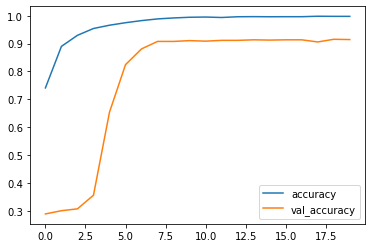

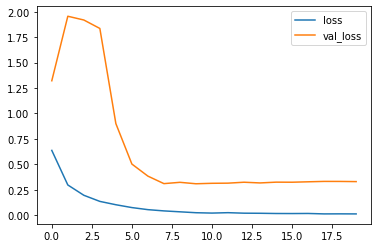

In [23]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                                               verbose=1, 
                                               restore_best_weights=True)

history = model.fit(train_imgs, 
                    train_df, 
                    batch_size=batch, 
                    epochs=20, 
                    callbacks=[es_callback, get_lr_callback(batch)], 
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [25]:
model.evaluate(test_imgs, test_df) 

34/34 [==============================] - 2s 65ms/step - loss: 0.3169 - accuracy: 0.9041


[0.316927969455719, 0.9040590524673462]

## 2. VGG 19

In [27]:
def build_model(img_size, n):
    inp = Input(shape=(img_size,img_size,n))
    resnet = tf.keras.applications.VGG19(input_shape=(img_size,img_size,n), 
                                            weights='imagenet', 
                                            include_top=False)
    x = resnet(inp)
    x = MaxPooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x) 
    opt = tf.keras.optimizers.SGD(momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(224, 3)
model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 512)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 3, 3, 3)           1539      
Total params: 20,025,923
Trainable params: 20,025,923
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                                               verbose=1, 
                                               restore_best_weights=True)

history = model.fit(train_imgs, 
                    train_df, 
                    batch_size=batch, 
                    epochs=25, 
                    callbacks=[es_callback, get_lr_callback(batch)], 
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('VGG 19 Architecture')
plt.show()